In [22]:
import sys
import os
import importlib
# Add the parent directory to the Python path
sys.path.append(os.path.abspath('..'))

import pybaseball


import IPython #type: ignore
import sqlite3
import pandas as pd # type: ignore
import numpy as np # type: ignore

import src
importlib.reload(src)
from src import *

In [75]:
hr = get_team_hits("NYY", False, 'home_run')
hits = get_team_hits("NYY", False, None)
store(hr, "2024_NYY", "home_runs")
store(hits, "2024_NYY", "hits")   
    
con = sqlite3.connect("2024_NYY")
cur = con.cursor()

IPython.display.clear_output()

In [76]:
def extract_final_values(row):
    calculated = simulate_row(row)
    last_time = max(calculated.keys())
    positions_f, velocities_f, accelerations_f = calculated[last_time]
    return {
        'x_f_sim': positions_f[0], 'y_f_sim': positions_f[1], 'z_f_sim': positions_f[2],
        'vx_f_sim': velocities_f[0], 'vy_f_sim': velocities_f[1], 'vz_f_sim': velocities_f[2],
        'ax_f_sim': accelerations_f[0], 'ay_f_sim': accelerations_f[1], 'az_f_sim': accelerations_f[2]
    }

final_values = hr.apply(extract_final_values, axis=1).apply(pd.Series)
for column in final_values.columns:
    hr[column] = final_values[column]


In [77]:
pitch_types = ['FA', 'FF', 'FT', 'FC', 'FS', 'SI', 'SF', 'SL', 'CH', 'CU', 'KC', 'KN', 'EP']


C:\Users\lukat\AppData\Local\Temp\ipykernel_31572\3314741855.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)



=== Detailed Analysis Interpretation ===

1. ANOVA Results (Pitch Type Impact):

Release Spin Rate:
  Statistical Significance: Significant differences (highly significant)
  P-value: 0.0000
  F-statistic: 32.0117

Launch Speed:
  Statistical Significance: No significant difference
  P-value: 0.2106
  F-statistic: 1.3234

Launch Angle:
  Statistical Significance: Significant differences (moderately significant)
  P-value: 0.0189
  F-statistic: 2.1228

Spray Angle:
  Statistical Significance: No significant difference
  P-value: 0.0705
  F-statistic: 1.7106

Spin Axis:
  Statistical Significance: Significant differences (highly significant)
  P-value: 0.0000
  F-statistic: 6.1155

2. Feature Relationships (Mutual Information):

Release Spin Rate:
  pfx_x: Weak relationship (Score: 0.0774)
  pfx_z: Weak relationship (Score: 0.0844)
  pitch_type_encoded: Moderate relationship (Score: 0.2901)

Launch Speed:
  pfx_x: Weak relationship (Score: 0.0000)
  pfx_z: Weak relationship (Score: 0.01

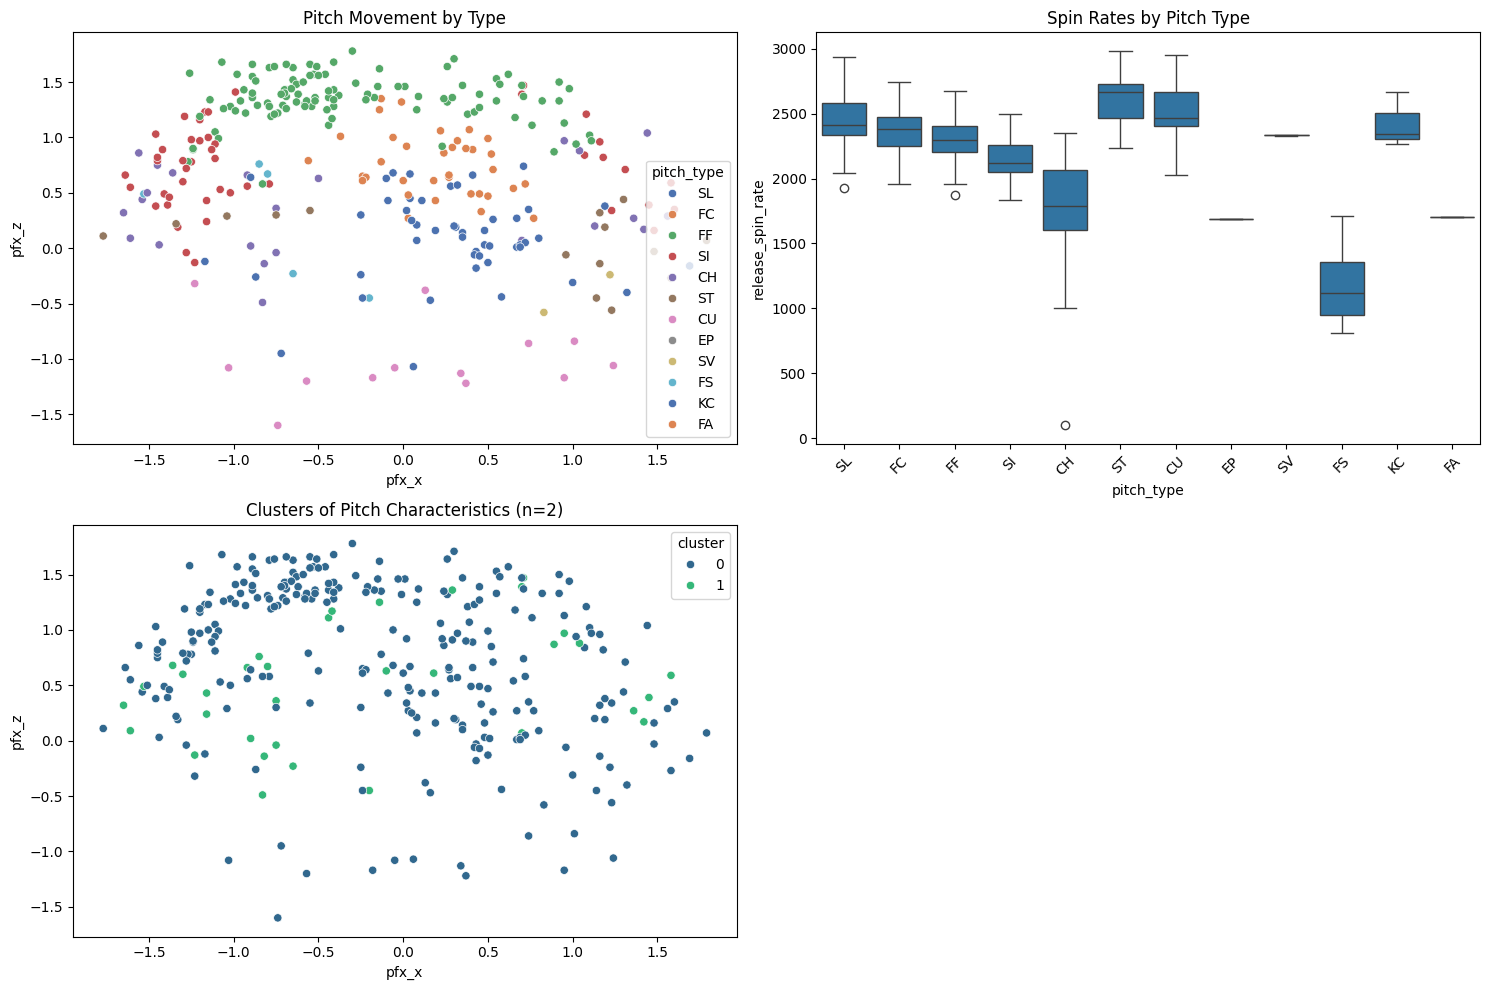

In [89]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def analyze_pitch_relationships(df):
    """
    Comprehensive analysis of pitch type relationships with trajectory parameters.
    """
    # Create a deep copy to avoid SettingWithCopyWarning
    df = df.copy()

    # Encode pitch types
    if 'pitch_type' not in df.columns:
        raise ValueError("The DataFrame must contain a 'pitch_type' column.")
    le = LabelEncoder()
    df['pitch_type_encoded'] = le.fit_transform(df['pitch_type'])

    # Prepare features and target variables
    features = ['pfx_x', 'pfx_z', 'pitch_type_encoded']
    targets = ['release_spin_rate', 'launch_speed', 'launch_angle', 'spray_angle', 'spin_axis']

    # Results dictionary to store analysis outcomes
    results = {
        'correlations': {},
        'mutual_info': {},
        'interpretation': {}
    }

    # Check for missing values in targets and features
    if df[features + targets].isnull().any().any():
        print("Warning: The DataFrame contains missing values. Null values will be handled by imputation.")
        # Impute missing values with column mean for numeric columns
        for col in features + targets:
            if df[col].isnull().any():
                df[col].fillna(df[col].mean(), inplace=True)

    # 1. Correlation Analysis
    for target in targets:
        if target not in df.columns:
            raise ValueError(f"The DataFrame must contain the '{target}' column.")
        
        # One-way ANOVA to check pitch type impact
        pitch_groups = [group[target].values for name, group in df.groupby('pitch_type')]
        f_statistic, p_value = stats.f_oneway(*pitch_groups)

        # Interpret ANOVA results
        interpretation = "No significant difference" if p_value > 0.05 else "Significant differences"
        if p_value < 0.001:
            interpretation += " (highly significant)"
        elif p_value < 0.01:
            interpretation += " (very significant)"
        elif p_value < 0.05:
            interpretation += " (moderately significant)"

        results['correlations'][target] = {
            'anova_f_statistic': f_statistic,
            'anova_p_value': p_value,
            'interpretation': interpretation
        }

    # 2. Mutual Information Analysis
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    for target in targets:
        y = df[target]
        if not np.issubdtype(y.dtype, np.number):
            raise ValueError(f"The target '{target}' must be numeric.")
        
        mi_scores = mutual_info_regression(X_scaled, y)

        # Interpret Mutual Information Scores
        mi_dict = dict(zip(features, mi_scores))
        results['mutual_info'][target] = mi_dict

        # Classify mutual information strength
        interpretation = {}
        for feature, score in mi_dict.items():
            if score < 0.1:
                interpretation[feature] = "Weak relationship"
            elif score < 0.3:
                interpretation[feature] = "Moderate relationship"
            else:
                interpretation[feature] = "Strong relationship"

        results['interpretation'][target] = interpretation

    # 3. Clustering Analysis
    cluster_features = ['pfx_x', 'pfx_z', 'release_spin_rate']
    if not all(f in df.columns for f in cluster_features):
        raise ValueError(f"The DataFrame must contain the following columns for clustering: {cluster_features}.")
    X_cluster = df[cluster_features]

    max_clusters = min(10, len(df) // 5)
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(X_cluster)
        score = silhouette_score(X_cluster, cluster_labels)
        silhouette_scores.append((n_clusters, score))

    optimal_clusters = max(silhouette_scores, key=lambda x: x[1])[0]
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(X_cluster)

    # Analyze pitch type distribution in clusters
    cluster_pitch_distribution = df.groupby(['cluster', 'pitch_type']).size().unstack(fill_value=0)
    results['cluster_pitch_distribution'] = cluster_pitch_distribution

    # 4. Visualization
    plt.figure(figsize=(15, 10))

    # Scatter plot of pitch movement
    plt.subplot(2, 2, 1)
    sns.scatterplot(data=df, x='pfx_x', y='pfx_z', hue='pitch_type', palette='deep')
    plt.title('Pitch Movement by Type')

    # Box plot of spin rates by pitch type
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df, x='pitch_type', y='release_spin_rate')
    plt.title('Spin Rates by Pitch Type')
    plt.xticks(rotation=45)

    # Cluster visualization
    plt.subplot(2, 2, 3)
    sns.scatterplot(data=df, x='pfx_x', y='pfx_z', hue='cluster', palette='viridis')
    plt.title(f'Clusters of Pitch Characteristics (n={optimal_clusters})')

    plt.tight_layout()
    plt.savefig('pitch_analysis_visualization.png')

    return results



def print_detailed_analysis(results):
    """
    Print a detailed, human-readable interpretation of the analysis results.
    """
    print("\n=== Detailed Analysis Interpretation ===")

    # ANOVA Results Interpretation
    print("\n1. ANOVA Results (Pitch Type Impact):")
    for target, stats in results['correlations'].items():
        print(f"\n{target.replace('_', ' ').title()}:")
        print(f"  Statistical Significance: {stats['interpretation']}")
        print(f"  P-value: {stats['anova_p_value']:.4f}")
        print(f"  F-statistic: {stats['anova_f_statistic']:.4f}")

    # Mutual Information Interpretation
    print("\n2. Feature Relationships (Mutual Information):")
    for target, interpretation in results['interpretation'].items():
        print(f"\n{target.replace('_', ' ').title()}:")
        for feature, relationship in interpretation.items():
            score = results['mutual_info'][target][feature]
            print(f"  {feature}: {relationship} (Score: {score:.4f})")

    # Cluster Distribution Interpretation
    print("\n3. Pitch Type Cluster Distribution:")
    dist = results['cluster_pitch_distribution']
    total_pitches = dist.sum().sum()

    for cluster, row in dist.iterrows():
        print(f"\nCluster {cluster}:")
        for pitch_type, count in row.items():
            percentage = (count / total_pitches) * 100
            if count > 0:
                print(f"  {pitch_type}: {count} pitches ({percentage:.2f}%)")


# Main execution function
def main():
    # Example data loading
    # hr = pd.read_csv('your_dataset.csv')
  # Replace with actual DataFrame
    # Ensure DataFrame has necessary columns
    required_columns = ['pitch_type', 'pfx_x', 'pfx_z', 'release_spin_rate', 
                        'launch_speed', 'launch_angle', 'spray_angle', 'spin_axis']
    for col in required_columns:
        if col not in hr.columns:
            raise ValueError(f"The input DataFrame must contain the column: {col}")

    # Run the analysis
    results = analyze_pitch_relationships(hr)

    # Print detailed interpretation
    print_detailed_analysis(results)


# Run standalone
if __name__ == "__main__":
    main()


C:\Users\lukat\AppData\Local\Temp\ipykernel_31572\345053565.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pitch_type_encoded'] = le.fit_transform(df['pitch_type'])
C:\Users\lukat\AppData\Local\Temp\ipykernel_31572\345053565.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(X_cluster)


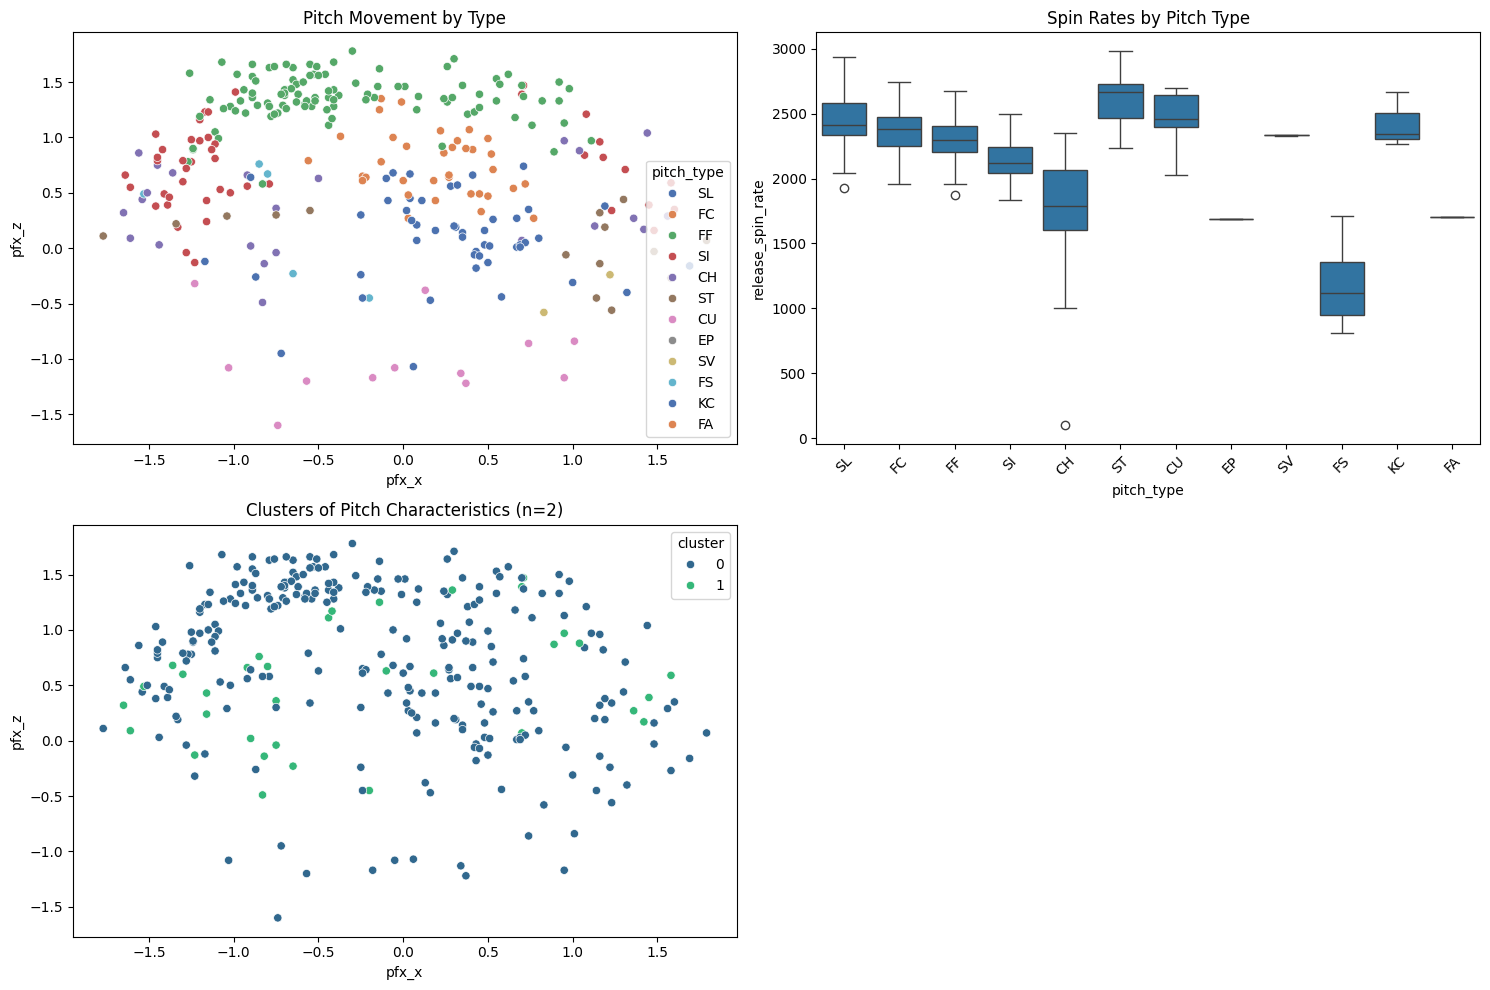

In [83]:
results = run_pitch_analysis(hr)